In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import optimize
from sklearn import metrics
from loading_data import *
from statsmodels.tsa.seasonal import seasonal_decompose

In [28]:
ncg_consumption, gaspool_consumption, the_consumption = read_consumption()
consumption_data = pd.concat([ncg_consumption.add(gaspool_consumption, fill_value=0), the_consumption])
consumption_data = pd.DataFrame(consumption_data, columns=["consumption"])

temperature = read_weather()

consumption_data_clean = consumption_data.dropna()
temperature_clean = temperature.dropna()

common_index = consumption_data_clean.index.intersection(temperature_clean.index)

consumption_data = consumption_data_clean.loc[common_index]
consumption_data = pd.DataFrame(consumption_data)
temperature = temperature_clean.loc[common_index]


In [29]:
# compter les na dans les series
print(consumption_data.isna().sum())
print(temperature.isna().sum())

consumption    0
dtype: int64
temperature_2m_max (°C)      0
temperature_2m_min (°C)      0
temperature_2m_mean (°C)     0
sunshine_duration (h)        0
wind_speed_10m_max (km/h)    0
dtype: int64


## Diagram temperature & natural gas consumption

In [31]:
consumption_data["consumption"].loc["2018/01/01":].corr(temperature["temperature_2m_mean (°C)"].loc["2018/01/01":])

np.float64(-0.9179922956114716)

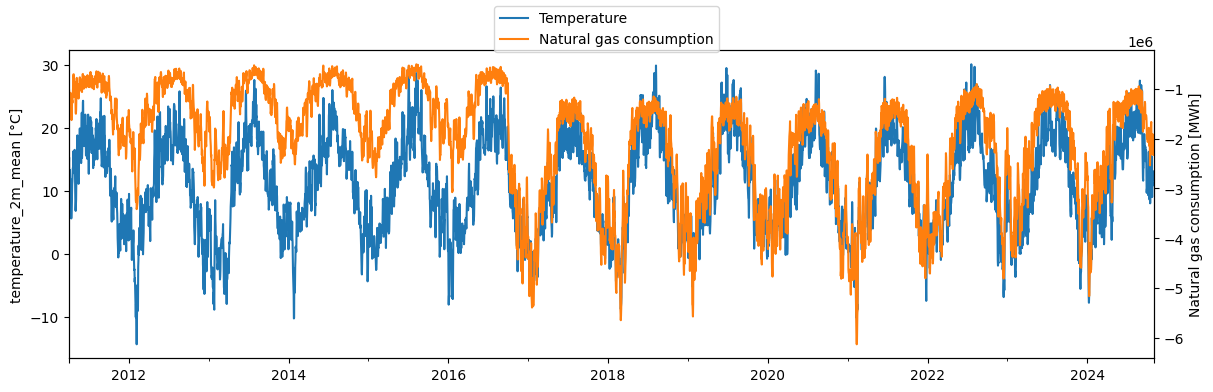

In [33]:
import os

fig, ax1 = plt.subplots(figsize=(14, 4))
ax2 = ax1.twinx()

# For both, only show data in 2021 and 2022
temperature["temperature_2m_mean (°C)"].plot(ax=ax1, color="tab:blue")
(consumption_data["consumption"] * -1).plot(ax=ax2, color="tab:orange") # Invert the consumption axis

# Labels and legend
ax1.set_ylabel("temperature_2m_mean [°C]")
ax2.set_ylabel("Natural gas consumption [MWh]")

# Legend for both plots in one
fig.legend(
    labels=["Temperature", "Natural gas consumption"],

    loc="upper center",
)

# Create directory if it does not exist
os.makedirs("diagrams", exist_ok=True)

# Save plot
fig.savefig("diagrams/data_analysis_003_001.svg", format="svg", bbox_inches="tight")

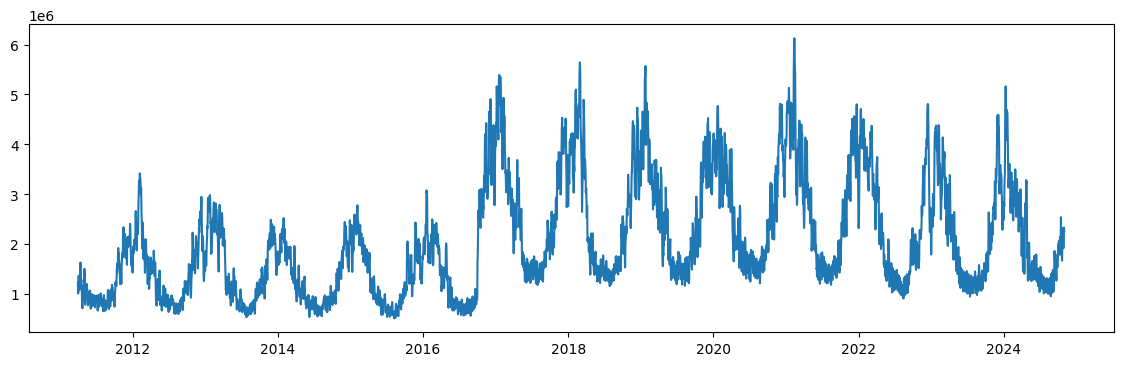

In [35]:
# gerer les dimension sur l'axe des x
fig, ax1 = plt.subplots(figsize=(14, 4))
plt.plot(consumption_data)

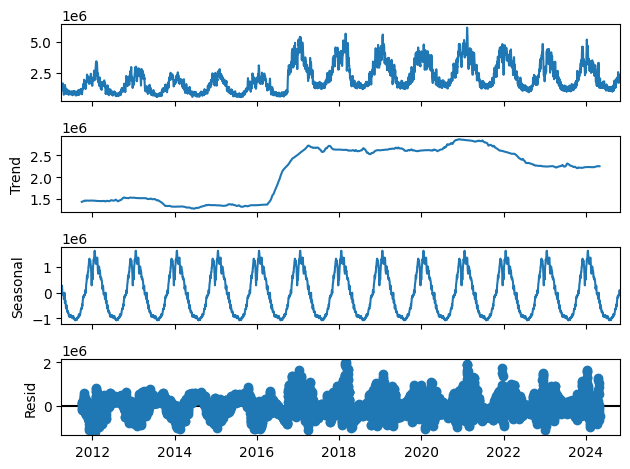

In [36]:

# Décomposition additive
result_add = seasonal_decompose(consumption_data, model='additive', period=365)  # Ajustez 'period' à la fréquence de vos données
result_add.plot()
plt.show()


## Regression analysis

In [13]:
def calculate_monthly_deviation(data, resample_freq='ME', agg_func='mean'):
    # Resample et agrégation mensuelle
    data_monthly = data.resample(resample_freq).agg(agg_func)
    
    # Moyenne par mois
    data_monthly_mean = data_monthly.groupby(data_monthly.index.month).mean()
    data_monthly_mean.index = pd.to_datetime(data_monthly_mean.index, format="%m").month_name()
    
    # Calcul des écarts
    monthly_deviation = pd.DataFrame()
    for month in data_monthly_mean.index:
         # Obtenir le numéro du mois (1 = janvier, ..., 12 = décembre)
        month_number = pd.to_datetime(month, format='%B').month
        # Filtrer les lignes du premier DataFrame correspondant au mois actuel
        monthly_values = data_monthly[data_monthly.index.month == month_number]
        # Récupérer la valeur moyenne pour le mois actuel dans le second DataFrame
        monthly_mean = data_monthly_mean.loc[month]
        # Calculer les écarts
        result = monthly_values - monthly_mean
        # Ajouter les écarts au DataFrame final
        monthly_deviation = pd.concat([monthly_deviation, result])
    
    return monthly_deviation.sort_index()


In [20]:
temperature_monthly_deviation = calculate_monthly_deviation(temperature, resample_freq='ME', agg_func='mean')
consumption_monthly_deviation = calculate_monthly_deviation(consumption_data, resample_freq='ME', agg_func='sum')

correlation = consumption_monthly_deviation.iloc[:, 0].corr(
    temperature_monthly_deviation["temperature_2m_mean (°C)"]
)
print(correlation)

-0.12228042637869665


C:\Users\pierr_s\AppData\Local\Temp\ipykernel_23916\1947924745.py:21: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  monthly_deviation = pd.concat([monthly_deviation, result])


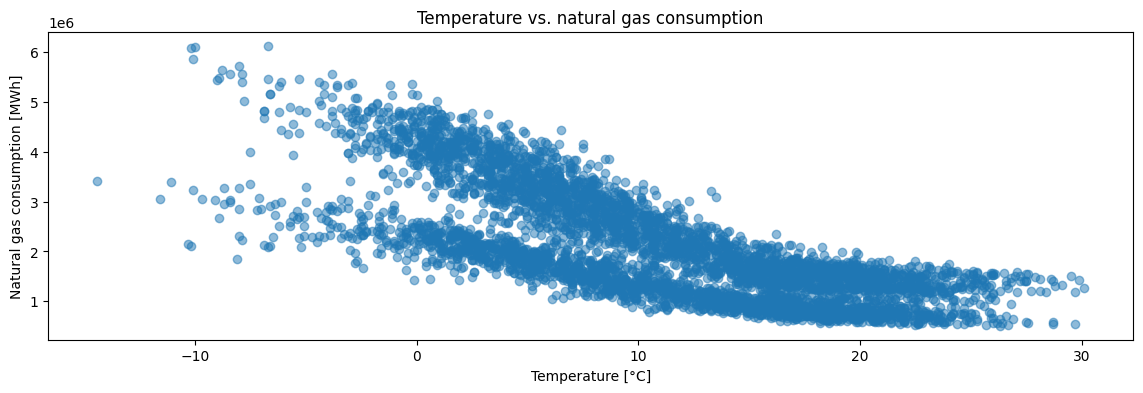

In [8]:
# Scatter plot of temperature and natural gas consumption
fig, ax = plt.subplots(figsize=(14, 4))
ax.scatter(temperature["temperature_2m_mean (°C)"], consumption_data, alpha=0.5) 

# Labels and legend
ax.set_xlabel("Temperature [°C]")
ax.set_ylabel("Natural gas consumption [MWh]")
ax.set_title("Temperature vs. natural gas consumption")

# Save plot
fig.savefig("diagrams/data_analysis_003_003.svg", format="svg", bbox_inches="tight")

0.5680183151915658


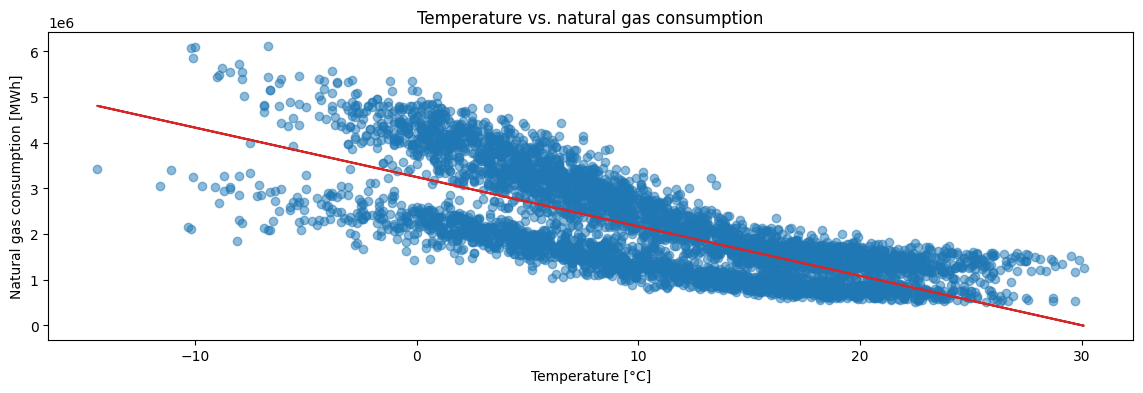

In [9]:
linear_regression = stats.linregress(temperature["temperature_2m_mean (°C)"], consumption_data)

# print r^2
print(linear_regression.rvalue**2)

# Plot linear regression
regression_y = linear_regression.slope * temperature["temperature_2m_mean (°C)"] + linear_regression.intercept

# Scatter plot of temperature and natural gas consumption
fig, ax = plt.subplots(figsize=(14, 4))
ax.scatter(temperature["temperature_2m_mean (°C)"], consumption_data, alpha=0.5)

# Plot linear regression
ax.plot(temperature["temperature_2m_mean (°C)"], regression_y, color="tab:red")

# Labels and legend
ax.set_xlabel("Temperature [°C]")
ax.set_ylabel("Natural gas consumption [MWh]")
ax.set_title("Temperature vs. natural gas consumption")

# Save plot
fig.savefig("diagrams/data_analysis_003_004.svg", format="svg", bbox_inches="tight")
